## 1.0 Import Libraries and Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix,
    roc_curve, precision_recall_curve, classification_report
)

import shap


In [2]:
data = pd.read_csv("dataset/churn_modelling.csv")
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## 2.0 Sanity check the data

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [4]:
data.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [5]:
print("Missing values: \n\n", data.isna().sum())

Missing values: 

 RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64


In [6]:
print("Unique values: \n\n", data.nunique())

Unique values: 

 RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64


In [7]:
data.select_dtypes(include = ['object']).head()

,Surname,Geography,Gender
0,Hargrave,France,Female
1,Hill,Spain,Female
2,Onio,France,Female
3,Boni,France,Female
4,Mitchell,Spain,Female


In [8]:
data.select_dtypes(include = ['int']).head()

,RowNumber,CustomerId,CreditScore,Age,Tenure,NumOfProducts,HasCrCard,IsActiveMember,Exited
0,1,15634602,619,42,2,1,1,1,1
1,2,15647311,608,41,1,1,0,1,0
2,3,15619304,502,42,8,3,1,0,1
3,4,15701354,699,39,1,2,0,0,0
4,5,15737888,850,43,2,1,1,1,0


In [9]:
data.select_dtypes(include = ['float']).head()

,Balance,EstimatedSalary
0,0.00,101348.88
1,83807.86,112542.58
2,159660.80,113931.57
3,0.00,93826.63
4,125510.82,79084.10


## 3.0 Quick EDA

In [10]:
# Target column is 'Exited'
churn_rate = data['Exited'].mean()   # since Exited is 0/1, mean = proportion of 1s
print(f"Churn rate: {churn_rate:.3f} ({churn_rate*100:.2f}%)")


Churn rate: 0.204 (20.37%)


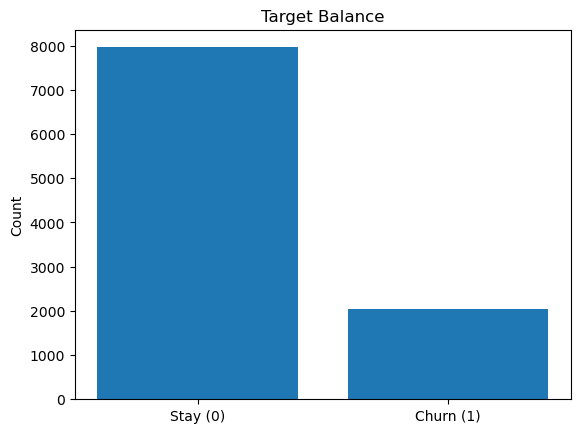

In [11]:
# 1) Target balance
churn_counts = data['Exited'].value_counts().sort_index()
plt.figure()
plt.bar(['Stay (0)', 'Churn (1)'], churn_counts.values)
plt.title('Target Balance')
plt.ylabel('Count')
plt.show()

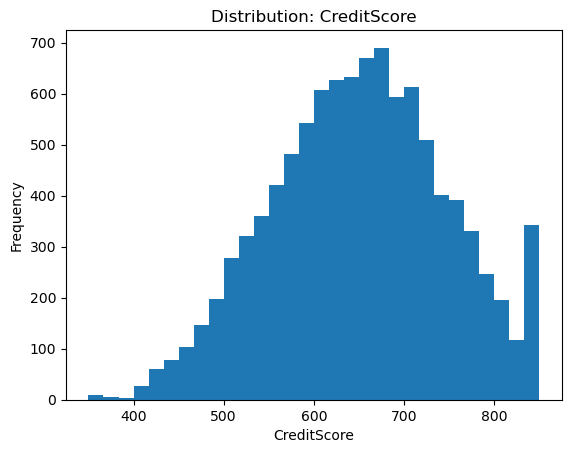

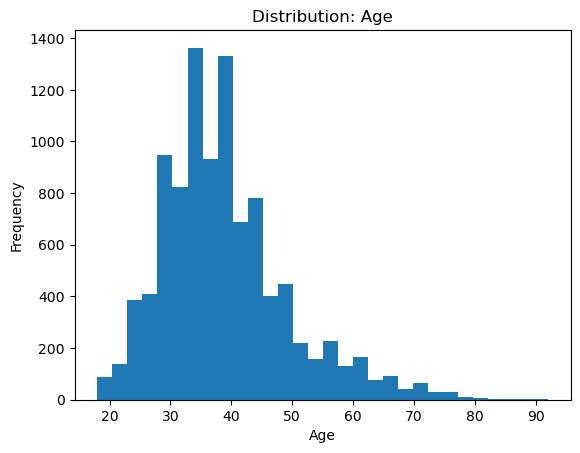

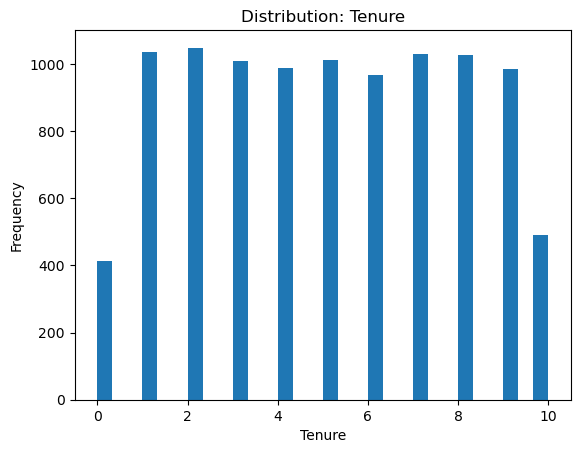

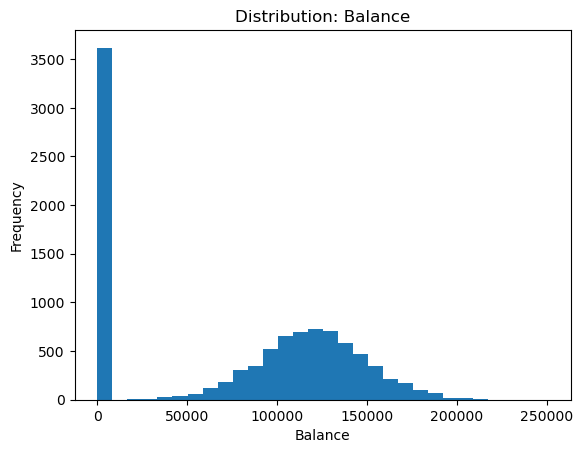

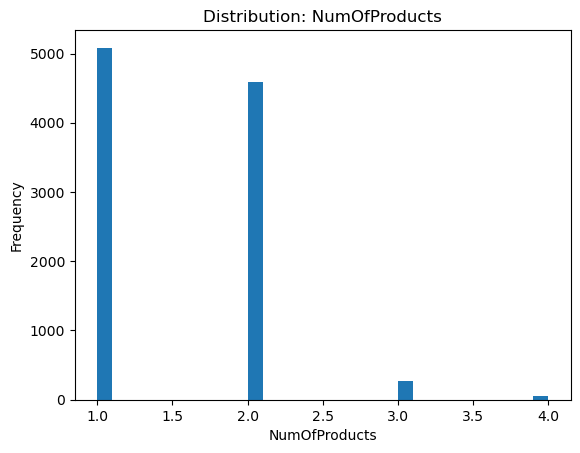

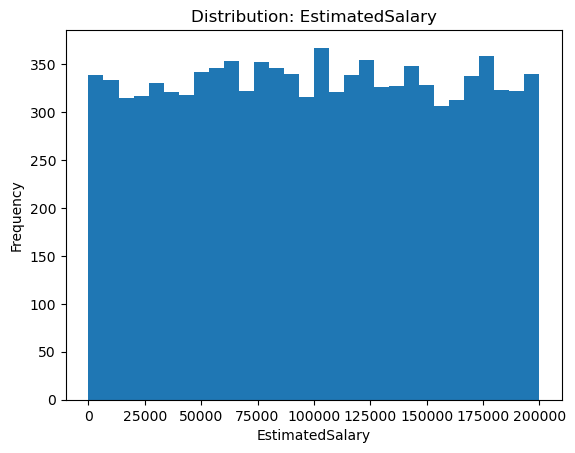

In [12]:
# 2) Numeric histograms
num_cols = ['CreditScore','Age','Tenure','Balance','NumOfProducts','EstimatedSalary']
for col in num_cols:
    plt.figure()
    plt.hist(data[col].dropna(), bins=30)
    plt.title(f'Distribution: {col}')
    plt.xlabel(col); plt.ylabel('Frequency')
    plt.show()

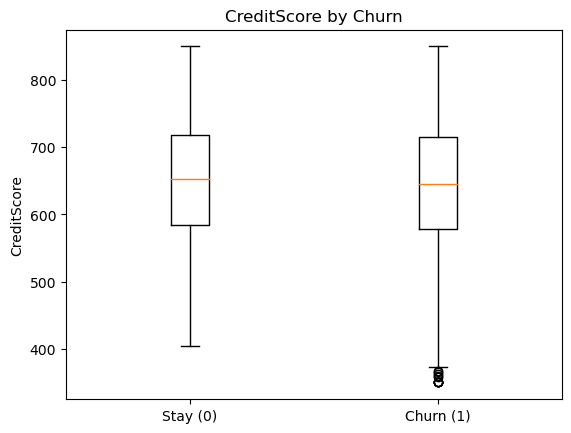

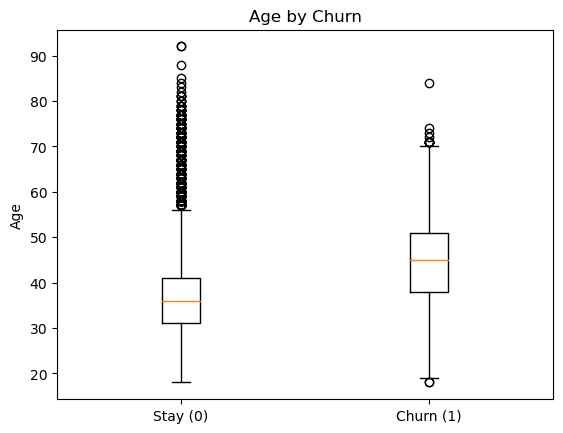

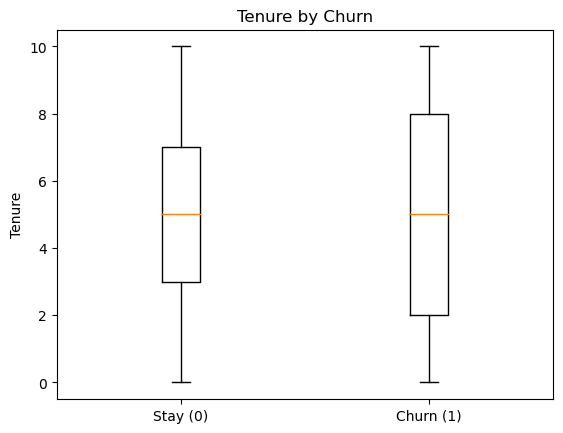

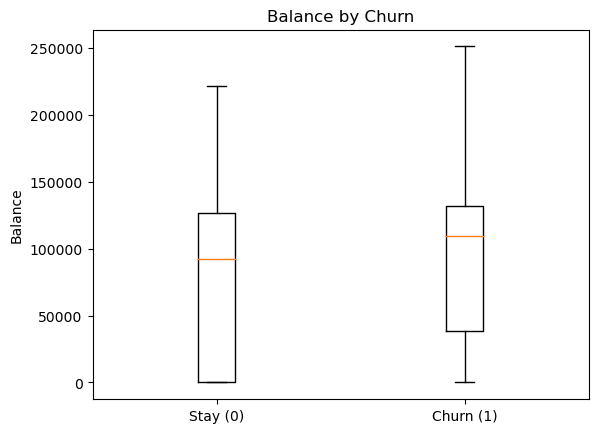

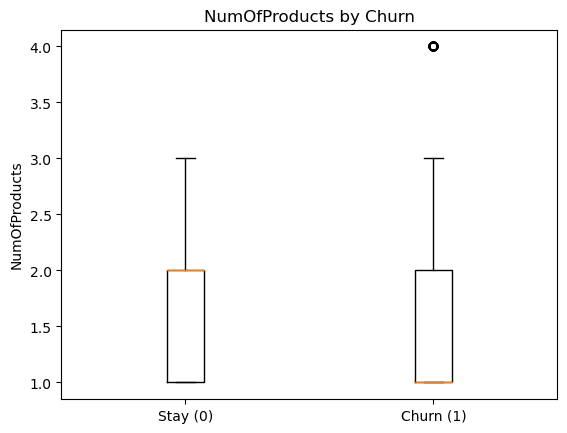

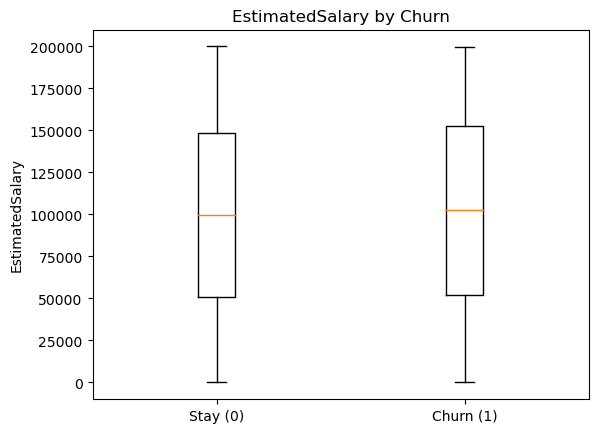

In [13]:
# 3) Boxplots by churn (spot differences in medians/outliers)
for col in num_cols:
    plt.figure()
    data0 = data.loc[data['Exited']==0, col].dropna()
    data1 = data.loc[data['Exited']==1, col].dropna()
    plt.boxplot([data0, data1], labels=['Stay (0)', 'Churn (1)'])
    plt.title(f'{col} by Churn')
    plt.ylabel(col)
    plt.show()


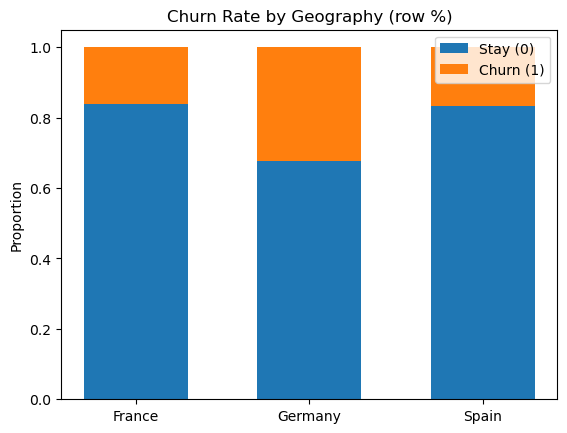

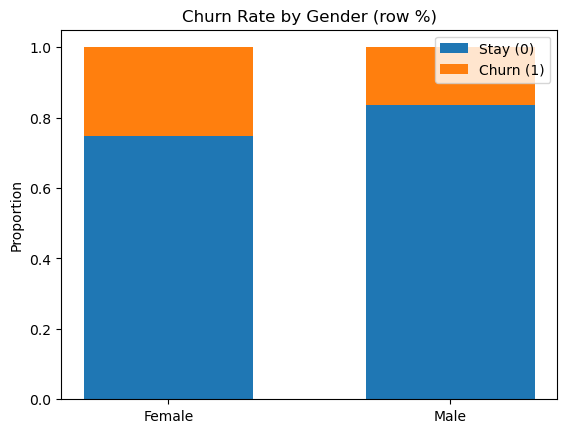

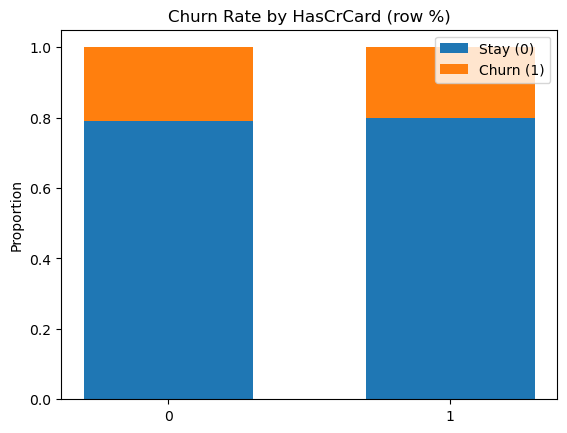

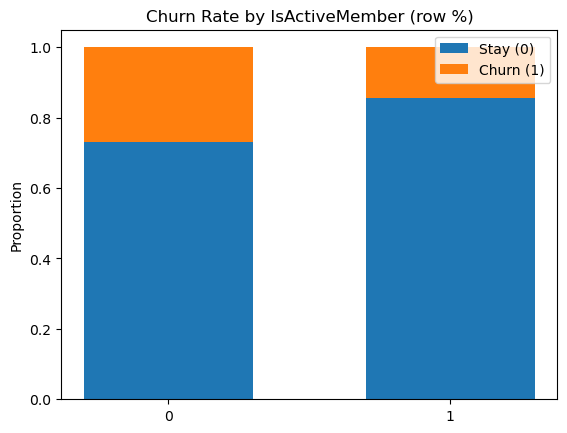

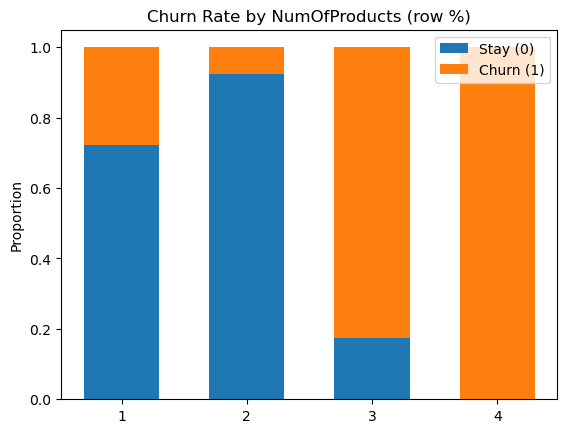

In [14]:
# 4) Simple categorical splits
cat_cols = ['Geography','Gender','HasCrCard','IsActiveMember','NumOfProducts']
for col in cat_cols:
    ct = pd.crosstab(data[col], data['Exited'])
    ct_ratio = ct.divide(ct.sum(axis=1), axis=0)  # row-wise %
    plt.figure()
    
    # stacked bar: 0 then 1
    idx = np.arange(len(ct_ratio.index))
    width = 0.6
    plt.bar(idx, ct_ratio[0].values, width, label='Stay (0)')
    plt.bar(idx, ct_ratio[1].values, width, bottom=ct_ratio[0].values, label='Churn (1)')
    plt.xticks(idx, ct_ratio.index, rotation=0)
    plt.title(f'Churn Rate by {col} (row %)')
    plt.ylabel('Proportion')
    plt.legend()
    plt.show()

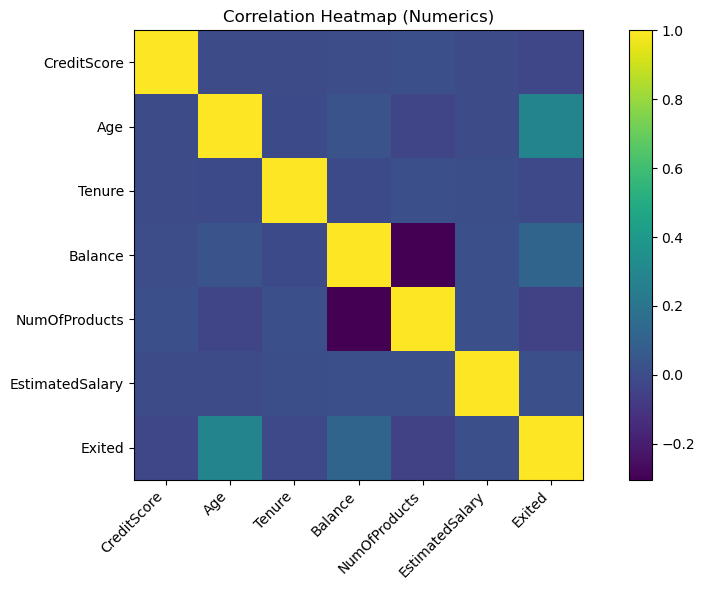

In [15]:
# 5) Correlation heatmap (numerics only)
plt.figure(figsize = (12, 6))
corr = data[num_cols + ['Exited']].corr(numeric_only=True)
im = plt.imshow(corr, interpolation='nearest')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha='right')
plt.yticks(range(len(corr.index)), corr.index)
plt.title('Correlation Heatmap (Numerics)')
plt.tight_layout()
plt.show()

## 4.0 Define features & drop leakage/IDs

In [16]:
drop_cols = ['RowNumber', 'CustomerId', 'Surname']

# Feature X, target y
y = data['Exited']
X = data.drop(columns = drop_cols + ['Exited'])

In [17]:
X.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,France,Female,42,2,0.00,1,1,1,101348.88
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58
2,502,France,Female,42,8,159660.80,3,1,0,113931.57
3,699,France,Female,39,1,0.00,2,0,0,93826.63
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10


In [18]:
y.head()

0    1
1    0
2    1
3    0
4    0
Name: Exited, dtype: int64

## 5.0 Train/test split (stratified)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 42)

y_train.mean(), y_test.mean()

(0.20375, 0.2035)

## 6.0 Preprocessing pipeline

In [20]:
num_features = ['CreditScore', 'Age', 'Tenure', 'Balance','NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
cat_features = ['Geography', 'Gender']

num_pipe = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'median')),
    ('scaler', StandardScaler())
])

cat_pipe = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown = 'ignore'))
])

preprocessor = ColumnTransformer(
    transformers =[
        ('num', num_pipe, num_features),
        ('cat', cat_pipe, cat_features)
    ],
    remainder = 'drop'
)

preprocessor.fit(X_train)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['CreditScore', 'Age', 'Tenure', 'Balance',
                                  'NumOfProducts', 'HasCrCard',
                                  'IsActiveMember', 'EstimatedSalary']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Geography', 'Gender'])])

## 7.0 Establish baselines

In [21]:
def evaluate_model(name, model, X_test, y_test): # Function to evaluate models
    y_prob = model.predict_proba(X_test)[:, 1]
    y_pred = (y_prob >= 0.5).astype(int)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division = 0)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_pred)
    pr_auc = average_precision_score(y_test, y_pred)
    
    print(f'\n == {name} ==')
    print(f'Accuracy: {acc:.3f}')
    print(f'Precision: {prec:.3f}')
    print(f"Recall: {rec:.3f}")
    print(f"F1: {f1:.3f}")
    print(f"ROC-AUC: {roc:.3f}")
    print(f"PR-AUC: {pr_auc:.3f}")
    print("\nConfusion matrix (threshold=0.5):\n", confusion_matrix(y_test, y_pred))
    print("\nClassification report:\n", classification_report(y_test, y_pred, zero_division=0))
    
    # curves for visualisation
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    precs, recs, _ = precision_recall_curve(y_test, y_prob)
    
    #ROC
    plt.figure()
    plt.plot(fpr, tpr, label = f'{name} (ROC-AUC = {roc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()
    

### 8.0 Dummy Baseline


 == Dummy (most frequent) ==
Accuracy: 0.796
Precision: 0.000
Recall: 0.000
F1: 0.000
ROC-AUC: 0.500
PR-AUC: 0.203

Confusion matrix (threshold=0.5):
 [[1593    0]
 [ 407    0]]

Classification report:
               precision    recall  f1-score   support

           0       0.80      1.00      0.89      1593
           1       0.00      0.00      0.00       407

    accuracy                           0.80      2000
   macro avg       0.40      0.50      0.44      2000
weighted avg       0.63      0.80      0.71      2000



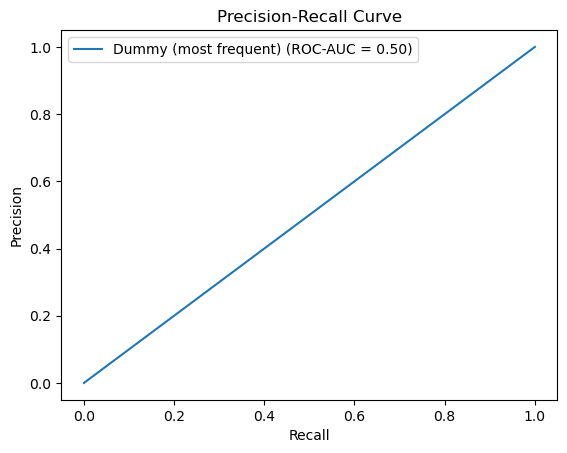

In [22]:
dummy_clf = Pipeline(steps = [
    ('prep', preprocessor),
    ('model', DummyClassifier(strategy = 'most_frequent'))
])

dummy_clf.fit(X_train, y_train)

evaluate_model('Dummy (most frequent)', dummy_clf, X_test, y_test)

Accuracy: 0.796 (looks good, but misleading because it just predicts “no churn” for everyone).

Precision/Recall/F1 for churn class = 0.0 - it completely fails to identify churners.

ROC-AUC = 0.50, PR-AUC = 0.20 - random guessing level.

### 9.0 Logistic Regression baseline


 == Logistic Regression ==
Accuracy: 0.808
Precision: 0.589
Recall: 0.187
F1: 0.284
ROC-AUC: 0.577
PR-AUC: 0.276

Confusion matrix (threshold=0.5):
 [[1540   53]
 [ 331   76]]

Classification report:
               precision    recall  f1-score   support

           0       0.82      0.97      0.89      1593
           1       0.59      0.19      0.28       407

    accuracy                           0.81      2000
   macro avg       0.71      0.58      0.59      2000
weighted avg       0.78      0.81      0.77      2000



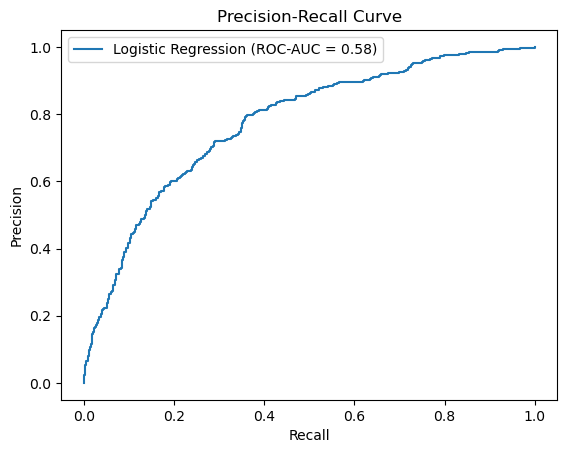

In [23]:
logreg = Pipeline(steps = [
    ('prep', preprocessor),
    ('model', LogisticRegression(max_iter = 1000, n_jobs = None))
])

logreg.fit(X_train, y_train)
evaluate_model('Logistic Regression', logreg, X_test, y_test)

Accuracy: 0.808 - slightly better than dummy.

Precision: 0.59, Recall: 0.19, F1: 0.28 for churn - catches some churners, but misses ~80% of them.

ROC-AUC = 0.58, PR-AUC = 0.28 - weak separation power.

## 10.0 A stronger tree model

#### 10.1 Random Forest Model


 == Random Forest ==
Accuracy: 0.859
Precision: 0.757
Recall: 0.452
F1: 0.566
ROC-AUC: 0.708
PR-AUC: 0.454

Confusion matrix (threshold=0.5):
 [[1534   59]
 [ 223  184]]

Classification report:
               precision    recall  f1-score   support

           0       0.87      0.96      0.92      1593
           1       0.76      0.45      0.57       407

    accuracy                           0.86      2000
   macro avg       0.82      0.71      0.74      2000
weighted avg       0.85      0.86      0.84      2000



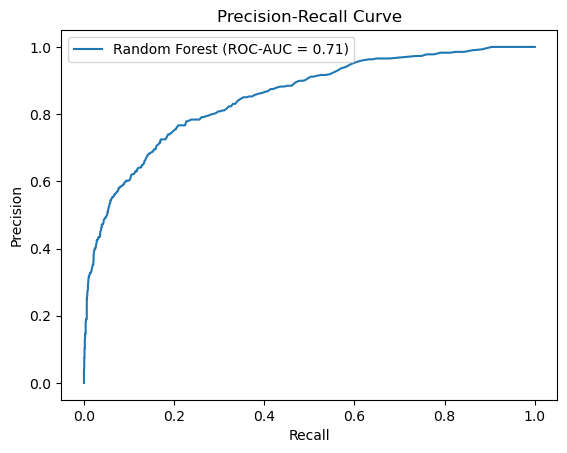

In [24]:
rf = Pipeline(steps = [
    ('prep', preprocessor),
    ('model', RandomForestClassifier(
    n_estimators = 400,
    max_depth = None,
    random_state = 42,
    n_jobs = -1,
    class_weight = None))
])

rf.fit(X_train, y_train)
evaluate_model('Random Forest', rf, X_test, y_test)

Accuracy: 0.859 - solid jump.

Precision: 0.76, Recall: 0.45, F1: 0.57 - much better balance: identifies ~45% of churners while keeping false positives relatively low.

ROC-AUC = 0.71, PR-AUC = 0.45 - big lift in discriminative ability compared to Logistic.

Handles non-linearities & feature interactions well - big step up.

#### 10.2 Gradient Boosting - XGBoost


 == XGBoost ==
Accuracy: 0.864
Precision: 0.757
Recall: 0.489
F1: 0.594
ROC-AUC: 0.724
PR-AUC: 0.474

Confusion matrix (threshold=0.5):
 [[1529   64]
 [ 208  199]]

Classification report:
               precision    recall  f1-score   support

           0       0.88      0.96      0.92      1593
           1       0.76      0.49      0.59       407

    accuracy                           0.86      2000
   macro avg       0.82      0.72      0.76      2000
weighted avg       0.86      0.86      0.85      2000



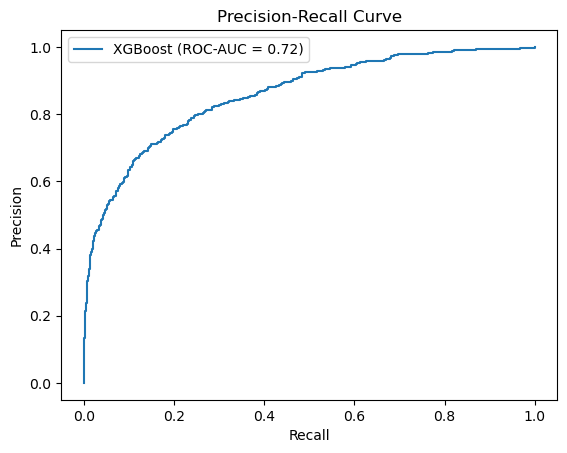

In [25]:
xgb = Pipeline(steps = [
    ('prep', preprocessor),
    ('model', XGBClassifier(
        n_estimators = 600,
        max_depth = 4,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        random_state=42,
        n_jobs=-1,
        eval_metric='logloss', 
        tree_method='hist'
))
])

xgb.fit(X_train, y_train)
evaluate_model('XGBoost', xgb, X_test, y_test)

Accuracy: 0.864 - highest overall.

Precision: 0.76, Recall: 0.49, F1: 0.59 - slightly higher recall than Random Forest while keeping precision the same.

ROC-AUC = 0.72, PR-AUC = 0.47- best curves overall.

Edges out Random Forest on both PR-AUC and ROC-AUC. Slightly better at recalling churners, which matters more in a business setting.

## Choose a decision threshold (business-aware)

#### Pick threshold for target recall (e.g., ~0.80)


**What the threshold is**

The model (XGBoost, RF, etc.) always outputs probabilities: e.g.
“This customer has a 0.72 probability of churn.”

To turn that into a decision (churn / not churn), we need a cutoff (threshold).

The Default is 0.5 (predict churn if probability ≥ 0.5).


**Why threshold matters**

By default, classifiers predict “churn” if probability ≥ 0.5.

But that 0.5 cutoff is arbitrary — it doesn’t reflect business needs.

In churn:

False Negative (FN) = missing a churner (very costly).

False Positive (FP) = offering a promo to a loyal customer (less costly).

So instead of accuracy, we tune the decision threshold to get more recall (catch more churners), even if precision drops.

**How it works**

Get predicted probabilities from model (not just 0/1).

Sweep thresholds (e.g., 0.0 - 1.0 in steps).

For each threshold: compute precision, recall.

Pick the lowest threshold that gives you recall ≥ 0.8.

In [26]:
y_prob = xgb.predict_proba(X_test)[:, 1]  
precs, recs, thresh = precision_recall_curve(y_test, y_prob)

# Average Precision (area under PR curve) for reference
ap = average_precision_score(y_test, y_prob)
roc = roc_auc_score(y_test, y_prob)
print(f"XGB ROC-AUC={roc:.3f}  PR-AUC(AP)={ap:.3f}")


XGB ROC-AUC=0.859  PR-AUC(AP)=0.702


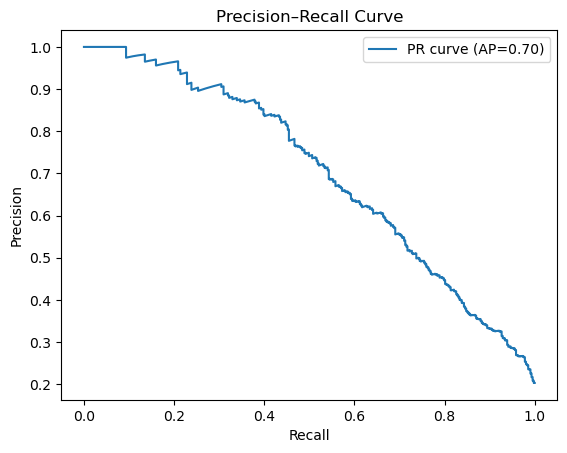

In [27]:
# Precision–Recall curve
plt.figure()
plt.plot(recs, precs, label=f'PR curve (AP={ap:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve')
plt.legend()
plt.show()


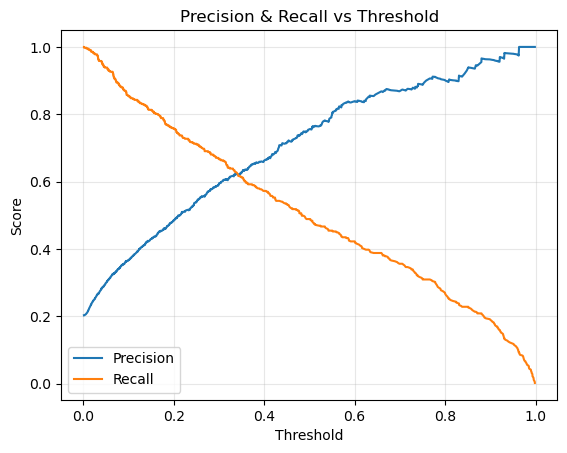

In [28]:
# 4) Precision & Recall vs Threshold
# Note: thresholds has length N-1 vs N for precisions/recalls; align by slicing
plt.figure()
plt.plot(thresh, precs[:-1], label='Precision')
plt.plot(thresh, recs[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision & Recall vs Threshold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [29]:
target_recall = 0.80 
candidates = [(p, r, t) for p, r, t in zip(precs[:-1], recs[:-1], thresh) if r >= target_recall]

if not candidates:
    print(f"No threshold achieved recall ≥ {target_recall:.2f}. Try lowering the target or improving the model.")
else:
    # candidate with the highest precision at/above the target recall
    best_p, best_r, best_t = max(candidates, key=lambda x: x[0])
    print(f"\nChosen threshold = {best_t:.3f}  (Recall={best_r:.3f}, Precision={best_p:.3f})")




Chosen threshold = 0.165  (Recall=0.801, Precision=0.447)


In [30]:
# Evaluating at this threshold
y_pred_custom = (y_prob >= best_t).astype(int)
print("Confusion matrix @ custom threshold:\n", confusion_matrix(y_test, y_pred_custom))
print(classification_report(y_test, y_pred_custom, zero_division=0))


Confusion matrix @ custom threshold:
 [[1190  403]
 [  81  326]]
              precision    recall  f1-score   support

           0       0.94      0.75      0.83      1593
           1       0.45      0.80      0.57       407

    accuracy                           0.76      2000
   macro avg       0.69      0.77      0.70      2000
weighted avg       0.84      0.76      0.78      2000



True churners caught (TP) = 326 out of 407 - ~80% recall.

False alarms (FP) = 403 - many non-churners are flagged.

Missed churners (FN) = 81 - much lower than before (we were missing >200 before).

**Business meaning**

Default threshold (0.5): high precision (~0.76) but recall <0.5 - We missed half the churners.

Tuned threshold (0.165): lower precision (~0.45) but recall ~0.80 - you caught most churners, at the cost of extra false positives.

*In churn prevention, this is usually a good trade-off: it’s better to annoy some loyal customers with a promo than to lose many churners.*

## Explainable AI (XAI)

In [31]:
import shap

best_model = xgb 

prep = best_model.named_steps['prep']
X_test_trans = prep.transform(X_test)

# Densify
try:
    import scipy.sparse as sp
    if sp.issparse(X_test_trans):
        X_test_trans = X_test_trans.toarray()
except Exception:
    pass

# Only the trained estimator (not the whole pipeline)
model_only = best_model.named_steps['model'] 


explainer = shap.Explainer(model_only)

sv_list = explainer.shap_values(X_test_trans)      # list [class0, class1]


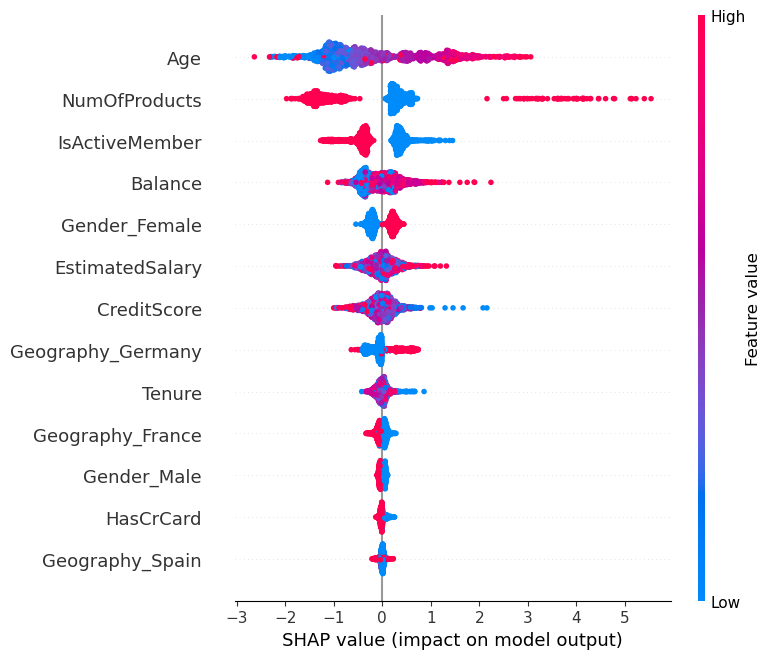

In [32]:
# Feature names after OneHot
ohe = best_model.named_steps['prep'].named_transformers_['cat'].named_steps['onehot']
cat_names = ohe.get_feature_names_out(cat_features)
feature_names = np.concatenate([num_features, cat_names])

sv = sv_list[1] if isinstance(sv_list, list) else sv_list
shap.summary_plot(sv, X_test_trans, feature_names=feature_names)

In [42]:
# x_row is transformed single row: x_row = X_test_transformed[idx:idx+1]
idx = 1  # choosing a row to explain
x_row = X_test_trans[idx:idx+1]
proba = best_model.predict_proba(X_test.iloc[idx:idx+1])[:, 1][0]
print(f"Predicted churn probability for row {idx}: {proba:.3f}")


# An Explanation object; add check_additivity=False to avoid bias column issues
sv_any = explainer.shap_values(x_row, check_additivity=False)

# normalize: binary classifier often returns [class0, class1]; newer may return array/Explanation
if isinstance(sv_any, list):
    sv_row = sv_any[1]  # positive class (churn)
else:
    sv_row = getattr(sv_any, "values", sv_any)  # Explanation or ndarray -> values

# trim optional bias/offset column if present
if sv_row.shape[1] == x_row.shape[1] + 1:
    sv_row = sv_row[:, :-1]

# transpose if SHAP flipped axes (features x samples)
if sv_row.shape == (x_row.shape[1], x_row.shape[0]):
    sv_row = sv_row.T

    
# final safety check
assert sv_row.shape[1] == x_row.shape[1] == len(feature_names), \
    (sv_row.shape, x_row.shape, len(feature_names))



Predicted churn probability for row 1: 0.084


In [43]:
print("x_row:", x_row.shape)
print("sv_row:", sv_row.shape)
print("n feature_names:", len(feature_names))


x_row: (1, 13)
sv_row: (1, 13)
n feature_names: 13


In [44]:
# sv_row currently has shape (1, 13, 2) -> [samples, features, classes]
# Selecting the positive class (index 1) so we get shape (1, 13)
if sv_row.ndim == 3 and sv_row.shape[-1] == 2:
    sv_row = sv_row[..., 1]   # -> (1, 13)

# An expected value compatible with explainer (positive class baseline)
exp_val = explainer.expected_value
if isinstance(exp_val, (list, tuple, np.ndarray)):
    exp_val = np.array(exp_val)
    exp_val = exp_val[-1] if exp_val.ndim > 0 else float(exp_val)

# Safety check
assert sv_row.shape == x_row.shape, (sv_row.shape, x_row.shape)



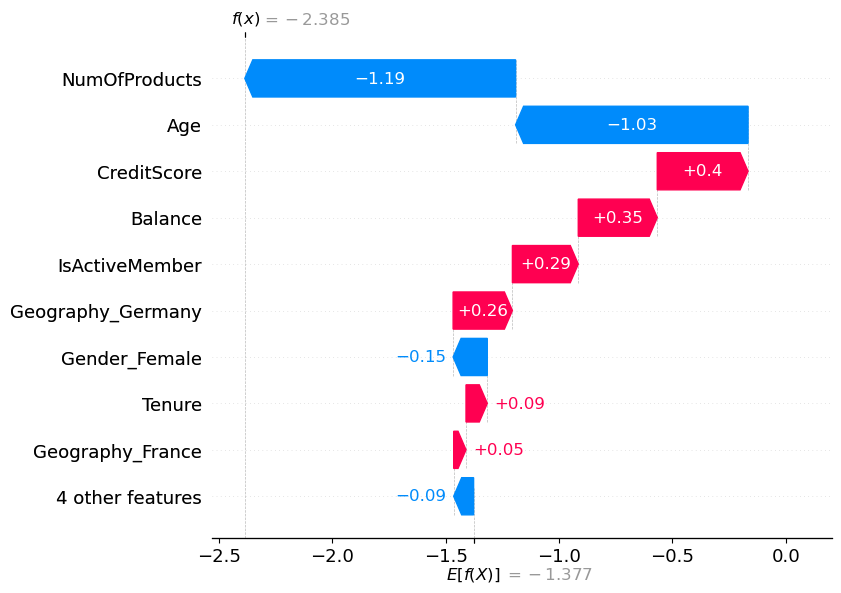

In [45]:
# Plot local explanation (legacy waterfall expects a 1D vector)
shap.plots._waterfall.waterfall_legacy(exp_val, sv_row[0], feature_names=feature_names)


In [47]:
# print top contributors that push toward churn
k = 5
contrib = pd.Series(sv_row[0], index=feature_names).sort_values(ascending=False)
print("\nTop features pushing toward churn:")
print(contrib.head(k).to_string())
print("\nTop features pushing to stay:")
print(contrib.tail(k)[::-1].to_string())


Top features pushing toward churn:
CreditScore          0.400315
Balance              0.348341
IsActiveMember       0.290460
Geography_Germany    0.261391
Tenure               0.093806

Top features pushing to stay:
NumOfProducts     -1.193984
Age               -1.025002
Gender_Female     -0.150694
Gender_Male       -0.033685
EstimatedSalary   -0.029667
